In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

## Describe Data

In [82]:
df_tweet = pd.read_csv('./ExtractedTweets.csv')

(array([0, 1]), [Text(0, 0, 'Democrat'), Text(1, 0, 'Republican')])

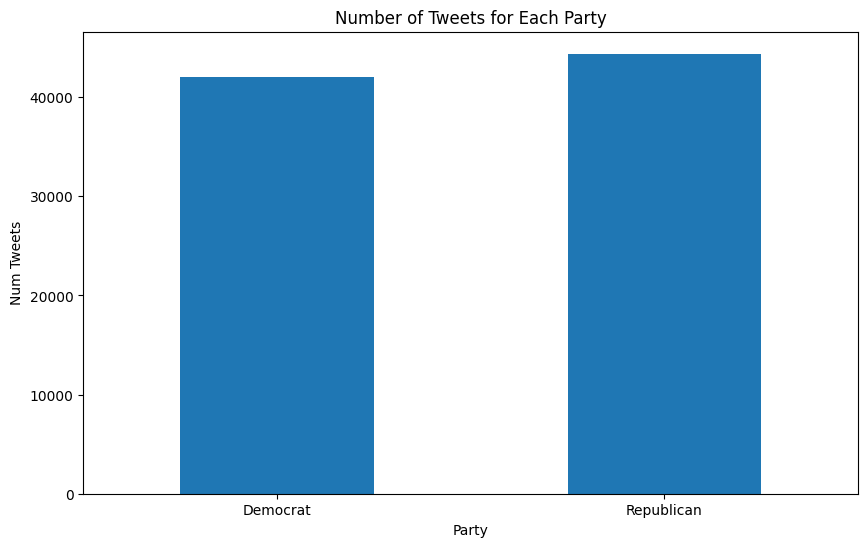

In [3]:
#calculate sum of points for each team
#calculate sum of points for each team
df_groups = df_tweet.groupby(['Party'])['Party'].count().reindex(['Democrat', 'Republican'])

#create bar plot with custom aesthetics
ax = df_groups.plot(kind='bar', title='Number of Tweets for Each Party', ylabel='Num Tweets', xlabel='Party', figsize=(10, 6))

#rotate x-axis ticks vertically
plt.xticks(rotation=0)
# plt.savefig('party_dis.png', bbox_inches = 'tight')

In [4]:
df_tweet_final = df_tweet[df_tweet['Tweet'].apply(lambda x: isinstance(x, str))].reset_index()

In [15]:
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base", use_fast=False)
roberta_model = SentenceTransformer('paraphrase-distilroberta-base-v1')

def normalize_encode_tweet(tweet):
    norm = tokenizer.normalizeTweet(tweet)
    encoded = roberta_model.encode(norm)
    return encoded

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
# show progress
tqdm.pandas()
# https://www.geeksforgeeks.org/create-a-new-column-in-pandas-dataframe-based-on-the-existing-columns/
df_tweet_final['embedding'] =  df_tweet_final.progress_apply(lambda row: normalize_encode_tweet(row.Tweet), axis=1)

In [ ]:
df_tweet_final.to_csv('tweet_roberta_embeddings.csv', index=False)

## Load trained embeddings

We recommend you to start here by importing the trained embeddings. Which can be found https://drive.google.com/file/d/1qogx047dUHZXd6yapjvxqNdGuBlUUZBZ/view?usp=sharing

In [5]:
df_tweet_final = pd.read_csv('./tweet_roberta_embeddings.csv', index_col=False)

In [6]:
df_tweet_final = df_tweet_final.drop('index', axis=1)
df_tweet_final = df_tweet_final.drop('Handle', axis=1)
df_tweet_final = df_tweet_final.dropna()
X = df_tweet_final['embedding'].astype(str).apply(lambda s: ([float(x.strip(" \n")) for x in s.strip("[]").split()])).values
y = df_tweet_final['Party'].map({'Democrat': 0, 'Republican': 1}).values
X = np.vstack(X)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=1)

Evaluation functions

In [8]:
def predict_evaluation(model, y_pred):
    # metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f'Accuracy:  {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall:    {recall}')
    print(f'F1 Score:  {f1}')

def accuracy_evaluation(model, y_pred, y_train_pred):
    # metrics
    test_accuracy = accuracy_score(y_test, y_pred)
    train_accuracy = accuracy_score(y_train, y_train_pred)

    print(f'Training Accuracy: {train_accuracy}')
    print(f'Testing Accuracy:  {test_accuracy}')

## Logistic Regression

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [10]:
log_reg = LogisticRegression(max_iter=1000)

In [11]:
# train model
trained_model_log = log_reg.fit(X_train, y_train)
# predict
y_pred_log = trained_model_log.predict(X_test)
y_train_pred_log = trained_model_log.predict(X_train)

In [12]:
predict_evaluation(trained_model_log, y_pred_log)
accuracy_evaluation(trained_model_log, y_pred_log, y_train_pred_log)                  

Accuracy:  0.6860976173953273
Precision: 0.6859809027777778
Recall:    0.71386630532972
F1 Score:  0.6996458610004427
Training Accuracy: 0.6995423076287569
Testing Accuracy:  0.6860976173953273


## SVM

In [13]:
from sklearn.svm import SVC

In [14]:
svclassifier = SVC(kernel='linear')

In [ ]:
# train model
trained_model = svclassifier.fit(X_train, y_train)
# predict
y_pred = trained_model.predict(X_test)

In [20]:
# predict training data
y_train_pred = trained_model.predict(X_train)

In [26]:
predict_evaluation(trained_model, y_pred)

Accuracy:  0.6874084355000386
Precision: 0.6826393789696542
Recall:    0.7281692261367058
F1 Score:  0.7046696291979311


In [33]:
accuracy_evaluation(trained_model, y_pred, y_train_pred)

Training Accuracy: 0.7044827415277342
Testing Accuracy:  0.6874084355000386


## Neural Network

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

In [64]:
def train_model(model,num_epochs,train_loader,test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    epoch_loss_list = []
    acc_train_list = []
    acc_val_list = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

            # Calculate training accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_loss_list.append(float(epoch_loss))
        train_acc = 100 * correct_train / total_train
        acc_train_list.append(float(train_acc))

        # Validation
        model.eval()
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_acc = 100 * correct_val / total_val
        acc_val_list.append(float(val_acc))
    print("Epoch [{}/{}], Loss: {:.4f}, Training Accuracy: {:.2f}%, Validation Accuracy: {:.2f}%".format(epoch+1, num_epochs, epoch_loss, train_acc, val_acc))
        #if epoch == num_epochs - 1:
    return [val_acc, epoch_loss_list, acc_train_list, acc_val_list]

## Feedforward

In [28]:
X_stack = np.vstack(X)
device = torch.device("cuda:0")

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=1)

In [19]:
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [74]:
torch_dataset_train = CustomDataset(X_train,y_train)
torch_dataset_test = CustomDataset(X_test,y_test)
train_loader = DataLoader(torch_dataset_train, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(torch_dataset_test, batch_size=64, shuffle=False, num_workers=2)

In [75]:
class FNN_Classifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1):
        super(FNN_Classifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc3(x))
        x = F.dropout(x,0.2)
        x = torch.sigmoid(self.fc4(x))

        return x

## 10-Fold Cross-Validation

In [76]:
#K_Fold Split
n_splits = 10
kf = KFold(n_splits=n_splits, shuffle=True, random_state=66)

In [78]:
##GRID Search
input_size = 768
num_classes = 2
hidden_list = [128,256,512]
epoch_list = [5,10,20]

best_acc = 0
for num_epochs in epoch_list:
    print("Total Epochs:",num_epochs)
    for hidden_size in hidden_list:
        print("Hidden Size:" ,hidden_size)
        val_acc_list = []
        for fold, (train_indices, val_indices) in enumerate(kf.split(torch_dataset_train)):
            # Create train and validation DataLoader instances for the current fold
            fnn_model = FNN_Classifier(input_size, hidden_size, num_classes)
            fnn_model.to(device)
            train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
            val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)
            train_split_loader = DataLoader(torch_dataset_train, batch_size=256, sampler=train_sampler)
            val_split_loader = DataLoader(torch_dataset_train, batch_size=256, sampler=val_sampler)
            val_acc,_1,_2,_3 = train_model(fnn_model, num_epochs,train_split_loader,val_split_loader)
            val_acc_list.append(float(val_acc))
            print("Fold:",fold+1)
        ave_val_acc = sum(val_acc_list)/ len(val_acc_list)
        if ave_val_acc > best_acc:
            best_acc = ave_val_acc
            torch.save(fnn_model,"./Best_FNN.pt")



Total Epochs: 5
Hidden Size: 128
Epoch [5/5], Loss: 0.4817, Training Accuracy: 76.75%, Validation Accuracy: 72.21%
Fold: 1
Epoch [5/5], Loss: 0.4837, Training Accuracy: 76.41%, Validation Accuracy: 72.67%
Fold: 2
Epoch [5/5], Loss: 0.4801, Training Accuracy: 76.88%, Validation Accuracy: 70.84%
Fold: 3
Epoch [5/5], Loss: 0.4827, Training Accuracy: 76.60%, Validation Accuracy: 70.70%
Fold: 4
Epoch [5/5], Loss: 0.4805, Training Accuracy: 76.73%, Validation Accuracy: 72.11%
Fold: 5
Epoch [5/5], Loss: 0.4831, Training Accuracy: 76.56%, Validation Accuracy: 71.88%
Fold: 6
Epoch [5/5], Loss: 0.4846, Training Accuracy: 76.18%, Validation Accuracy: 70.72%
Fold: 7
Epoch [5/5], Loss: 0.4831, Training Accuracy: 76.56%, Validation Accuracy: 72.14%
Fold: 8
Epoch [5/5], Loss: 0.4832, Training Accuracy: 76.54%, Validation Accuracy: 71.56%
Fold: 9
Epoch [5/5], Loss: 0.4801, Training Accuracy: 76.86%, Validation Accuracy: 71.70%
Fold: 10
Hidden Size: 256
Epoch [5/5], Loss: 0.4642, Training Accuracy: 78.

In [79]:
best_fnn_model = torch.load("./Best_FNN.pt")

In [40]:
#Show model parameter
for name, param in best_fnn_model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

fc1.weight tensor([[-0.0920,  0.0291, -0.0934,  ...,  0.0819, -0.0245, -0.0696],
        [-0.0321, -0.0454,  0.0892,  ...,  0.0501, -0.0344, -0.0218],
        [-0.0745,  0.0218, -0.0779,  ..., -0.0258, -0.0041, -0.0106],
        ...,
        [ 0.0304,  0.0027, -0.0004,  ..., -0.0769,  0.0130,  0.0107],
        [ 0.0480, -0.0027, -0.0425,  ..., -0.0669, -0.1556, -0.0107],
        [ 0.0564, -0.0662,  0.0369,  ..., -0.0562, -0.0198,  0.0145]],
       device='cuda:0')
fc1.bias tensor([-0.0114,  0.0192, -0.0399, -0.0213, -0.0140, -0.0096, -0.0508,  0.0214,
        -0.0463, -0.0171, -0.0068, -0.0270, -0.0285, -0.0625, -0.0283, -0.0361,
        -0.0258, -0.0464, -0.0137, -0.0264, -0.0382, -0.0442,  0.0134,  0.0139,
        -0.0480,  0.0056,  0.0143,  0.0312, -0.0281, -0.0203, -0.0509, -0.0152,
         0.0306,  0.0114, -0.0067, -0.0009, -0.0406,  0.0254,  0.0026, -0.0479,
         0.0224, -0.0360, -0.0179,  0.0160,  0.0080, -0.0516, -0.0228,  0.0250,
        -0.0232, -0.0313, -0.0304, -0.0242

## Evaluate Test Set

In [80]:
def evaluate(model, dataloader, device):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():  # Disable gradient calculations for faster evaluation
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)

            total_correct += (predictions == targets).sum().item()
            total_samples += targets.size(0)

    accuracy = total_correct / total_samples
    return accuracy

In [81]:
test_accuracy = evaluate(best_fnn_model, test_loader, device)
print("Test accuracy: {:.2f}%".format(test_accuracy * 100))

Test accuracy: 72.50%


## Recursive

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X_stack, y, test_size = 0.3, random_state=1)

In [84]:
class CustomDataset_RNN(Dataset):
    def __init__(self, data, labels):
        self.data = torch.tensor(data, dtype=torch.float32).unsqueeze(1)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [85]:
torch_dataset_train = CustomDataset_RNN(X_train,y_train)
torch_dataset_test = CustomDataset_RNN(X_test,y_test)
train_loader_rnn = DataLoader(torch_dataset_train, batch_size=64, shuffle=True, num_workers=2)
test_loader_rnn = DataLoader(torch_dataset_test, batch_size=64, shuffle=False, num_workers=2)

In [86]:
class TextLSTM(nn.Module):
    def __init__(self, embedding_dim, hidden_size, num_layers=2):
        super(TextLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM layers
        self.lstm = nn.LSTM(embedding_dim, hidden_size, num_layers, batch_first=True)

        # Fully connected layer to produce output
        self.fc = nn.Linear(hidden_size, 2)  # Output size is 2 for two classes (0 and 1)

    def forward(self, x):
        # Initialize hidden and cell states with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Pass input (embedded text) through LSTM layers
        out, _ = self.lstm(x, (h0, c0))

        # Pass the output of the LSTM through the fully connected layer
        out = self.fc(out[:, -1, :])

        return out

### GRID Search

In [87]:
import csv

embedding_dim = 768
input_size = 768
num_classes = 2
hidden_list = [128,256,512]
epoch_list = [5,10,20]

best_acc = 0
for num_epochs in epoch_list:
    print("Total Epochs:",num_epochs)
    for hidden_size in hidden_list:
        print("Hidden Size:" ,hidden_size)
        val_acc_list = []
        val_acc_epoch_list = []
        train_acc_epoch_list = []
        loss_epoch_list = []

        for fold, (train_indices, val_indices) in enumerate(kf.split(torch_dataset_train)):
            # Create train and validation DataLoader instances for the current fold
            rnn_model = TextLSTM(embedding_dim, hidden_size)
            rnn_model.to(device)
            train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
            val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)
            train_split_loader = DataLoader(torch_dataset_train, batch_size=256, sampler=train_sampler)
            val_split_loader = DataLoader(torch_dataset_train, batch_size=256, sampler=val_sampler)
            val_acc, epoch_loss_list, acc_train_list, acc_val_list = train_model(rnn_model, num_epochs,train_split_loader,val_split_loader)
            val_acc_list.append(float(val_acc))
            print("Fold:",fold+1)


            loss_epoch_csv_name = "./train_criteria/RNN_"+str(num_epochs)+"_epoch_"+str(hidden_size)+"_nodes_"+str(fold+1)+"fold_loss.csv"
            acc_train_csv_name = "./train_criteria/RNN_"+str(num_epochs)+"_epoch_"+str(hidden_size)+"_nodes_"+str(fold+1)+"fold_t_acc.csv"
            acc_val_csv_name = "./train_criteria/RNN_"+str(num_epochs)+"_epoch_"+str(hidden_size)+"_nodes_"+str(fold+1)+"fold_v_acc.csv"
            with open(loss_epoch_csv_name,'w',newline='') as file:
                writer = csv.writer(file)
                for element in epoch_loss_list:
                    writer.writerow([element])
            with open(acc_train_csv_name,'w',newline='') as file:
                writer = csv.writer(file)
                for element in acc_train_list:
                    writer.writerow([element])
            with open(acc_val_csv_name,'w',newline='') as file:
                writer = csv.writer(file)
                for element in acc_val_list:
                    writer.writerow([element])
        ave_val_acc = sum(val_acc_list)/ len(val_acc_list)
        if ave_val_acc > best_acc:
            best_acc = ave_val_acc
            torch.save(rnn_model,"./Best_RNN.pt")
            with open("./Best_RNN_Model_Hyper.txt",'w',newline='') as file:
                file.write(str(num_epochs)+","+str(hidden_size))
            

Total Epochs: 5
Hidden Size: 128
Epoch [5/5], Loss: 0.3806, Training Accuracy: 79.18%, Validation Accuracy: 72.34%
Fold: 1
Epoch [5/5], Loss: 0.3864, Training Accuracy: 78.84%, Validation Accuracy: 73.76%
Fold: 2
Epoch [5/5], Loss: 0.3835, Training Accuracy: 78.97%, Validation Accuracy: 72.82%
Fold: 3
Epoch [5/5], Loss: 0.3833, Training Accuracy: 79.01%, Validation Accuracy: 70.39%
Fold: 4
Epoch [5/5], Loss: 0.3816, Training Accuracy: 79.25%, Validation Accuracy: 73.36%
Fold: 5
Epoch [5/5], Loss: 0.3805, Training Accuracy: 79.24%, Validation Accuracy: 72.95%
Fold: 6
Epoch [5/5], Loss: 0.3814, Training Accuracy: 79.13%, Validation Accuracy: 71.79%
Fold: 7
Epoch [5/5], Loss: 0.3829, Training Accuracy: 79.15%, Validation Accuracy: 72.42%
Fold: 8
Epoch [5/5], Loss: 0.3831, Training Accuracy: 79.13%, Validation Accuracy: 72.46%
Fold: 9
Epoch [5/5], Loss: 0.3864, Training Accuracy: 78.89%, Validation Accuracy: 73.10%
Fold: 10
Hidden Size: 256
Epoch [5/5], Loss: 0.3692, Training Accuracy: 79.

In [88]:
best_rnn_model = torch.load("./Best_RNN.pt")

In [89]:
test_accuracy_2 = evaluate(best_rnn_model, test_loader_rnn, device)
print("Test accuracy: {:.2f}%".format(test_accuracy_2 * 100))

Test accuracy: 73.49%


## Plot performance comparison

In [52]:
import matplotlib.pyplot as plt

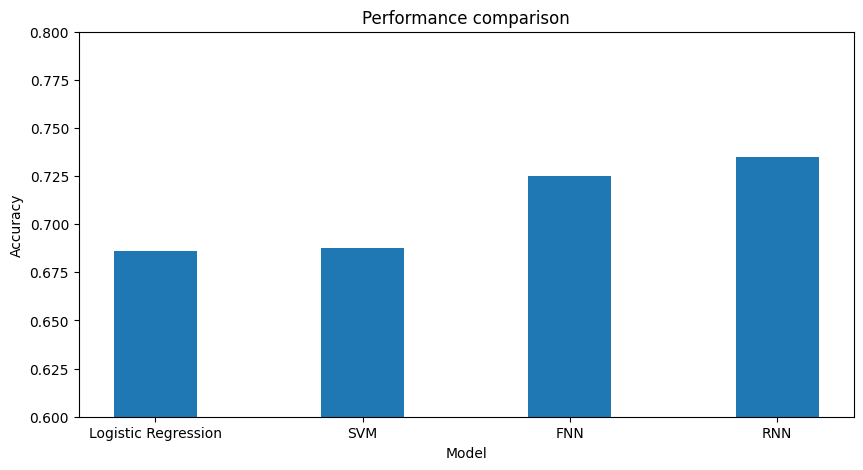

In [90]:
# creating the dataset
data = {'Logistic Regression':0.6861, 'SVM':0.6874, 'FNN':0.7250, 'RNN':0.7349}
models = list(data.keys())
accuracy = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(models, accuracy, width = 0.4)

plt.ylim(0.6, 0.8)

plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Performance comparison")

plt.show()

### Validation_acc vs Train_acc

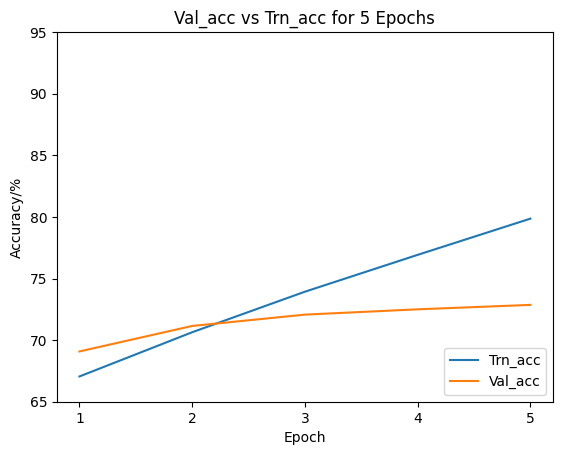

In [126]:
x1 = np.array([1,2,3,4,5])
y1 = np.array([67.05,70.64,73.93,76.92,79.86])
plt.plot(x1, y1)

x2 = np.array([1,2,3,4,5])
y2 = np.array([69.08,71.15,72.07,72.50,72.86])
plt.plot(x2,y2)
plt.xticks([1,2,3,4,5])
plt.xlabel("Epoch")
plt.ylabel("Accuracy/%")
plt.ylim(65,95)
plt.title("Val_acc vs Trn_acc for 5 Epochs")
plt.legend(["Trn_acc", "Val_acc"], loc ="lower right")

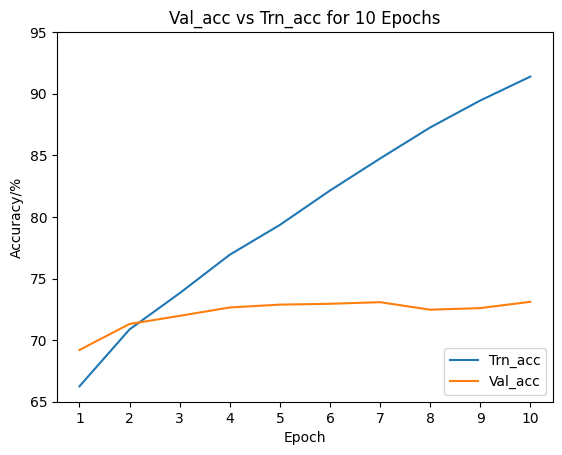

In [127]:
x1 = np.array([1,2,3,4,5,6,7,8,9,10])
y1 = np.array([66.25,70.87,73.81,76.93,79.35,82.14,84.74,87.26,89.45,91.39])
plt.plot(x1, y1)

y2 = np.array([69.20,71.31,71.97,72.65,72.88,72.95,73.08,72.47,72.60,73.11])
plt.plot(x1,y2)
plt.xticks([1,2,3,4,5,6,7,8,9,10])
plt.xlabel("Epoch")
plt.ylim(65,95)
plt.ylabel("Accuracy/%")
plt.title("Val_acc vs Trn_acc for 10 Epochs")
plt.legend(["Trn_acc", "Val_acc"], loc ="lower right")